In [ ]:
!pip install -q kaggle

In [ ]:
%%bash
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download edoardovantaggiato/covid19-xray-two-proposed-databases

100%|██████████| 3.53G/3.53G [00:18<00:00, 202MB/s]


In [ ]:
!unzip -qq "covid.zip"

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:


train=tf.keras.utils.image_dataset_from_directory('/content/Datasets/3-classes/Train',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=32,image_size=(256,256),shuffle=True,validation_split=0.0,
                                                  interpolation='bilinear',seed=8,)
valid=tf.keras.utils.image_dataset_from_directory('/content/Datasets/3-classes/Val',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=32,image_size=(256,256),shuffle=True,
                                                  interpolation='bilinear',seed=8,)
test=tf.keras.utils.image_dataset_from_directory('/content/Datasets/3-classes/Test',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                 batch_size=32,image_size=(256,256),shuffle=False,
                                                 interpolation='bilinear',seed=8,)



Found 1212 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 621 files belonging to 3 classes.


In [ ]:
print('Total training images:',train.cardinality()*32)
print('Total validation images:',valid.cardinality()*32)
print('Total test images:',test.cardinality()*32)
training_classes:list=train.class_names
valid_classses:list=valid.class_names
test_classes:list=test.class_names
assert training_classes==valid_classses==test_classes,'class count in train, valid and test set is not same'
print('Class names:',training_classes)

Total training images: tf.Tensor(1216, shape=(), dtype=int64)
Total validation images: tf.Tensor(320, shape=(), dtype=int64)
Total test images: tf.Tensor(640, shape=(), dtype=int64)
Class names: ['Covid-19', 'Normal', 'Pneumonia']


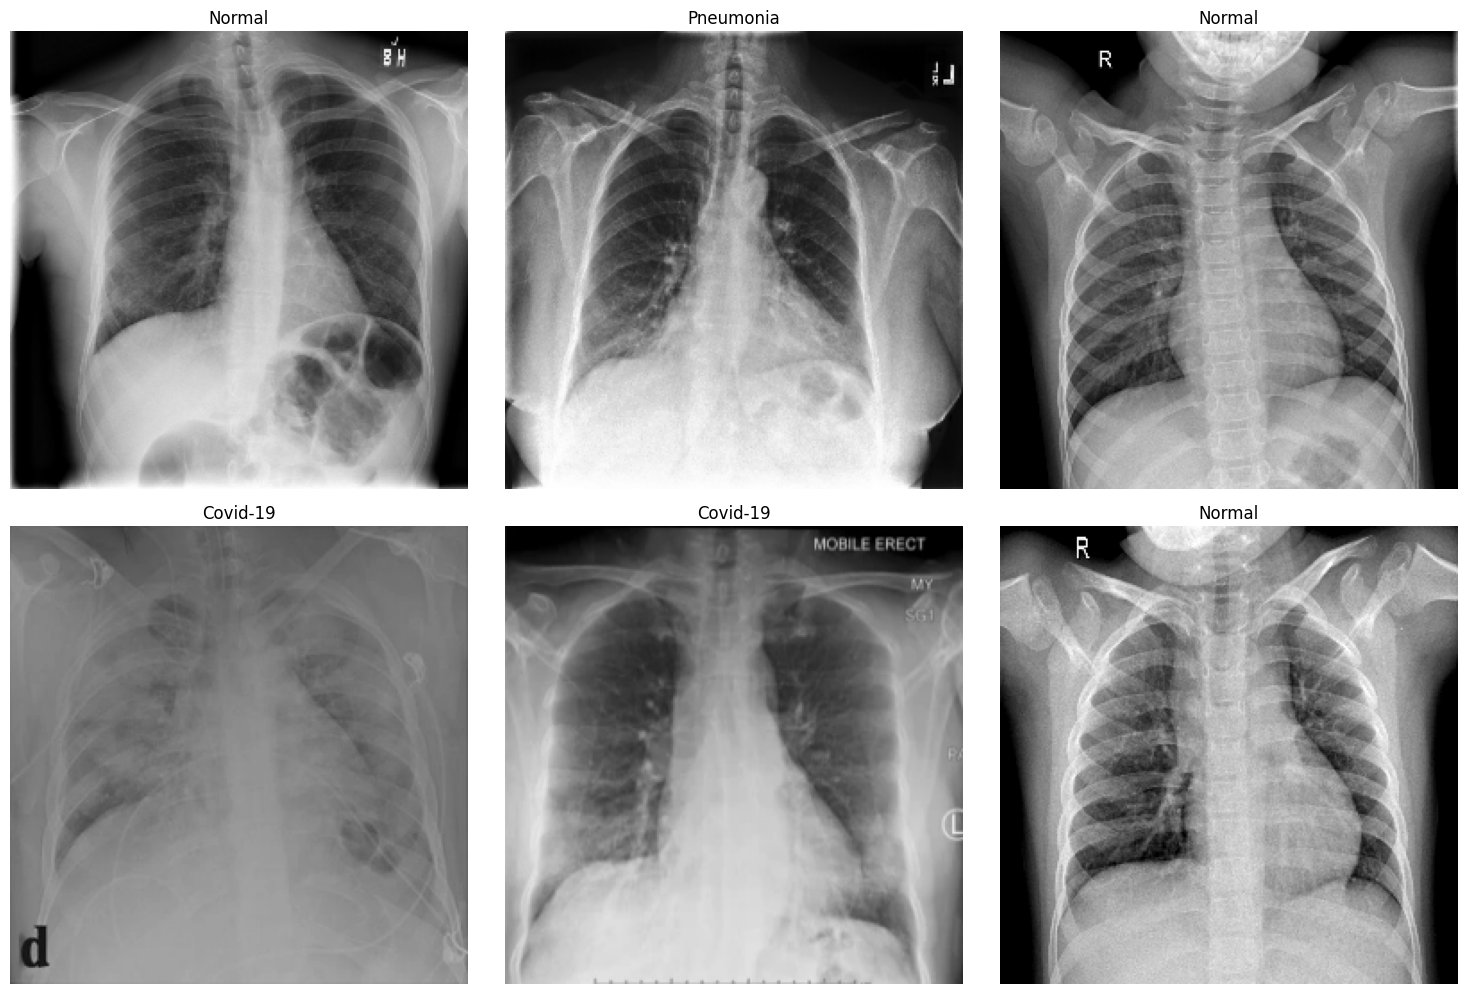

In [ ]:
for images,labels in train.take(1):break;
                                       # get a batch of data
images_to_plot:int=6                                                            # number of images to plot
plt.figure(figsize=(15,15))                                                     # figure size
for index in range(images_to_plot):                                             # loop over image index
  plt.subplot(3,3,index+1)                                                      # subplot rows = 3, columns = 3
  plt.imshow(images[index].numpy().astype('uint8'))                             # make plot image
  plt.axis('off')                                                               # make axis off
  plt.title(training_classes[labels[index].numpy()])                            # make add labels as class names
plt.tight_layout()                                                              # adjust layout space
plt.show()

In [ ]:
print('Maximum pixel values:',tf.reduce_max(images))                            # maximum pixel values in inputs
print('Minimum pixel values:',tf.reduce_min(images))                            # minimum pixel values in inputs
print('Object type of inputs (X):',type(images))                                # input types
print('Data type in inputs (X):',images.dtype)                                  # data type in inputs
print('Object type of outputs (y):',type(labels))                               # output types
print('Data type in outputs (X):',labels.dtype)

Maximum pixel values: tf.Tensor(255.0, shape=(), dtype=float32)
Minimum pixel values: tf.Tensor(0.0, shape=(), dtype=float32)
Object type of inputs (X): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in inputs (X): <dtype: 'float32'>
Object type of outputs (y): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in outputs (X): <dtype: 'int32'>


In [ ]:
random_flip=tf.keras.layers.RandomFlip('horizontal_and_vertical',name='random_flip')# random flip layer
random_zoom=tf.keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1,name='random_zoom')# random zoom layer
random_rotate=tf.keras.layers.RandomRotation(0.3,name='random_rotate')          # random rotate layers
random_brightness=tf.keras.layers.RandomBrightness(0.3,value_range=(0.0,255.0),name='random_brightness')# random brightness layer
augmentations=[random_flip,random_zoom,random_rotate,random_brightness]         # make list of data augmentation
# make apply augmentation on training data
for augmentation in augmentations:
  train.map(lambda images,labels: (augmentation(images),labels))

In [ ]:
base_model=tf.keras.applications.VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))
base_model.trainable=False

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
inputs=tf.keras.layers.Input(shape=(224,224,3),batch_size=None,name='model_inputs')                                 # add input layer
model_x=tf.keras.layers.Rescaling(1/255,offset=0.0,name='rescaler')(inputs)                                         # rescale inputs
model_x=base_model(model_x)                                                                                         # feed inputs to base model
model_x=tf.keras.layers.Flatten(name='flatten')(model_x)                                                            # make flatten outputs
model_x=tf.keras.layers.Dense(1024,activation='relu')(model_x)                                                      # apply dense layer
outputs=tf.keras.layers.Dense(len(training_classes),activation='softmax')(model_x)                                  # output layer
model=tf.keras.Model(inputs=[inputs],outputs=[outputs],name='custom_vgg16')                                         # build model
model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=True,layer_range=None)

Model: "custom_vgg16"
___________________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           Trainable  
 model_inputs (InputLayer)                            [(None, 224, 224, 3)]                           0                 Y          
                                                                                                                                   
 rescaler (Rescaling)                                 (None, 224, 224, 3)                             0                 Y          
                                                                                                                                   
 vgg16 (Functional)                                   (None, 7, 7, 512)                               14714688          N          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [ ]:
print('Maximum pixel values:',tf.reduce_max(images))                            # maximum pixel values in inputs
print('Minimum pixel values:',tf.reduce_min(images))                            # minimum pixel values in inputs
print('Object type of inputs (X):',type(images))                                # input types
print('Data type in inputs (X):',images.dtype)                                  # data type in inputs
print('Object type of outputs (y):',type(labels))                               # output types
print('Data type in outputs (X):',labels.dtype)

Maximum pixel values: tf.Tensor(255.0, shape=(), dtype=float32)
Minimum pixel values: tf.Tensor(0.0, shape=(), dtype=float32)
Object type of inputs (X): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in inputs (X): <dtype: 'float32'>
Object type of outputs (y): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in outputs (X): <dtype: 'int32'>


In [ ]:
random_flip=tf.keras.layers.RandomFlip('horizontal_and_vertical',name='random_flip')                      # random flip layer
random_zoom=tf.keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1,name='random_zoom')             # random zoom layer
random_rotate=tf.keras.layers.RandomRotation(0.3,name='random_rotate')                                    # random rotate layers
random_brightness=tf.keras.layers.RandomBrightness(0.3,value_range=(0.0,255.0),name='random_brightness')  # random brightness layer
augmentations=[random_flip,random_zoom,random_rotate,random_brightness]                                   # make list of data augmentation
resizer=tf.keras.layers.Resizing(224,224,interpolation='nearest',name='rescaler')
# make apply augmentation on training data
for augmentation in augmentations:
  train.map(lambda images,labels: (augmentation(images),labels))                                          # make apply augmentation
train=train.map(lambda images,labels: (resizer(images),labels))
valid=valid.map(lambda images,labels: (resizer(images),labels))
test=test.map(lambda images,labels: (resizer(images),labels))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',min_delta=0,patience=10,verbose=1,mode='auto',restore_best_weights=True)

# make train model
history=model.fit(train,batch_size=128,epochs=10_000,verbose=2,callbacks=[early_stop],validation_split=0,validation_data=valid,
                  shuffle=True)

Epoch 1/10000
38/38 - 47s - loss: 2.8568 - sparse_categorical_accuracy: 0.6427 - val_loss: 0.5661 - val_sparse_categorical_accuracy: 0.7600 - 47s/epoch - 1s/step
Epoch 2/10000
38/38 - 21s - loss: 0.2667 - sparse_categorical_accuracy: 0.9068 - val_loss: 0.3479 - val_sparse_categorical_accuracy: 0.8667 - 21s/epoch - 553ms/step
Epoch 3/10000
38/38 - 20s - loss: 0.1677 - sparse_categorical_accuracy: 0.9497 - val_loss: 0.3012 - val_sparse_categorical_accuracy: 0.8867 - 20s/epoch - 535ms/step
Epoch 4/10000
38/38 - 19s - loss: 0.0977 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.2934 - val_sparse_categorical_accuracy: 0.8867 - 19s/epoch - 498ms/step
Epoch 5/10000
38/38 - 18s - loss: 0.0697 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.2873 - val_sparse_categorical_accuracy: 0.8833 - 18s/epoch - 487ms/step
Epoch 6/10000
38/38 - 21s - loss: 0.0481 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.2635 - val_sparse_categorical_accuracy: 0.8967 - 21s/epoch - 561ms/step
Epoch 7/10000

In [ ]:
# see model history (first five epoches)
import pandas as pd
pd.DataFrame(history.history).head()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,2.856787,0.642739,0.566147,0.760000
1,0.266732,0.906766,0.347930,0.866667
2,0.167732,0.949670,0.301230,0.886667
3,0.097661,0.969472,0.293401,0.886667
4,0.069740,0.983498,0.287325,0.883333


In [ ]:
# see model history (last five epoches)
pd.DataFrame(history.history).tail()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
20,0.002765,1.0,0.311433,0.886667
21,0.002677,1.0,0.327014,0.893333
22,0.002330,1.0,0.317367,0.893333
23,0.002141,1.0,0.341941,0.890000
24,0.001970,1.0,0.333538,0.893333


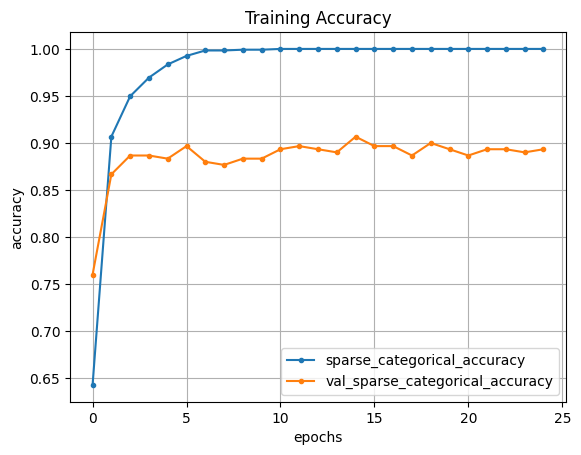

In [ ]:
# make plot training accuracy and validation accuracy
pd.DataFrame(history.history)[['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot(marker='.') # make plot
plt.grid(),plt.title('Training Accuracy'),plt.xlabel('epochs'),plt.ylabel('accuracy')                             # add grid, title and axis labels
plt.show()                                                                                                        # make plot show

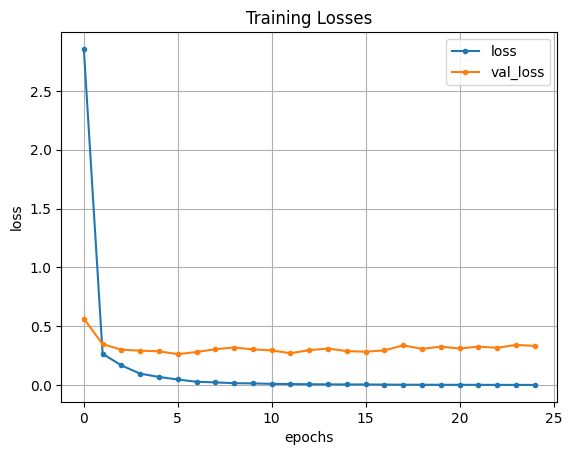

In [ ]:
# make plot training losses and validation losses
pd.DataFrame(history.history)[['loss','val_loss']].plot(marker='.')             # make plot
plt.grid(),plt.title('Training Losses'),plt.xlabel('epochs'),plt.ylabel('loss') # add grid, title and axis labels
plt.show()

In [ ]:
# evaluate model
results=model.evaluate(test,batch_size=None,verbose="auto",sample_weight=None,return_dict=True)
print('Testing results:',results)

20/20 [==============================] - 10s 499ms/step - loss: 1.3301 - sparse_categorical_accuracy: 0.7488
Testing results: {'loss': 1.3301149606704712, 'sparse_categorical_accuracy': 0.748792290687561}


In [ ]:
# make save model (weights and configuration)
model.save('Disease_Classsification_vgg16',overwrite=True,save_format=None)

In [ ]:
!zip -r -qq "Disease_Classsification_vgg16.zip" "Disease_Classsification_vgg16"                                                     # make zip model
# make auto download model weights
from google.colab import files                                                  # load file class
files.download('Disease_Classsification_vgg16.zip')